# MARBLE vs CEBRA multianimal consistency

Checking for consistent and interpretable embeddings with MARBLE and CEBRA.

This notebook is adapted from the CEBRA notebook demonstration on consistency. For comparison we have re-used a number of their function and it is mostly based on what is presented in CEBRA in [Figure 4](https://cebra.ai/docs/cebra-figures/figures/Figure1.html).

In [5]:
!pip install cebra elephant

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle

from cebra import CEBRA

import MARBLE
from rat_utils import *

## Load the data

In [2]:
!mkdir data
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609512 -O data/rat_data.pkl

with open('data/rat_data.pkl', 'rb') as handle:
    hippocampus_pos = pickle.load(handle)

mkdir: cannot create directory ‘data’: File exists
File ‘data/rat_data.pkl’ already there; not retrieving.


## Load the models and get the embeddings

In [3]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609532 -O data/cebra_behaviour_achilles_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609530 -O data/cebra_behaviour_buddy_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609529 -O data/cebra_behaviour_cicero_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609536 -O data/cebra_behaviour_gatsby_3D.pt

!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609533 -O data/cebra_time_achilles_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609531 -O data/cebra_time_buddy_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609535 -O data/cebra_time_cicero_3D.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7609534 -O data/cebra_time_gatsby_3D.pt

time_models, time_embeddings = {}, {}
posdir_models, posdir_embeddings = {}, {}
left, right = {}, {}

for rat in list(hippocampus_pos.keys()):
    # time constrative models
    time_models[rat] = cebra.CEBRA.load(f"data/cebra_time_{rat}_3D.pt")
    time_embeddings[rat] = time_models[rat].transform(hippocampus_pos[rat]['neural'])
    
    # behavioral contrastive models
    posdir_models[rat] = cebra.CEBRA.load(f"data/cebra_behaviour_{rat}_3D.pt")
    posdir_embeddings[rat] = posdir_models[rat].transform(hippocampus_pos[rat]['neural'])
    
    # left and right labels for the embedding
    right[rat] = hippocampus_pos[rat]['continuous_index'][:,1] == 1
    left[rat] = hippocampus_pos[rat]['continuous_index'][:,2] == 1

File ‘data/cebra_behaviour_achilles.pt’ already there; not retrieving.
File ‘data/cebra_behaviour_buddy.pt’ already there; not retrieving.
File ‘data/cebra_behaviour_cicero.pt’ already there; not retrieving.
File ‘data/cebra_behaviour_gatsby.pt’ already there; not retrieving.
File ‘data/cebra_time_achilles.pt’ already there; not retrieving.
File ‘data/cebra_time_buddy.pt’ already there; not retrieving.
File ‘data/cebra_time_cicero.pt’ already there; not retrieving.
File ‘data/cebra_time_gatsby.pt’ already there; not retrieving.


In [6]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7657256 -O data/marble_achilles_3D.pth
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7657252 -O data/marble_buddy_3D.pth
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7657257 -O data/marble_cicero_3D.pth
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7657254 -O data/marble_gatsby_3D.pth

labels_marble, marble_embeddings, left_marble, right_marble = {}, {}, {}, {}

for rat in list(hippocampus_pos.keys()):

    spikes = hippocampus_pos[rat]["neural"].numpy().T
    labels = hippocampus_pos[rat]['continuous_index']
    
    # process data
    data, labels, _ = convert_spikes_to_rates(spikes, labels, pca_n=10)

    # load trained model
    marble_model = MARBLE.net(data, loadpath=f"data/marble_{rat}_3D.pth")

    # generate embedding of test data
    data = marble_model.transform(data)
    
    labels_marble[rat] = labels
    marble_embeddings[rat] = data.emb.numpy()
    
    # left and right labels for the embedding
    right_marble[rat] = labels_marble[rat][:,1] == 1
    left_marble[rat] = labels_marble[rat][:,2] == 1    

File ‘data/marble_achilles_3D.pth’ already there; not retrieving.
File ‘data/marble_buddy_3D.pth’ already there; not retrieving.
File ‘data/marble_cicero_3D.pth’ already there; not retrieving.
File ‘data/marble_gatsby_3D.pth’ already there; not retrieving.

---- Settings: 

epochs : 100
order : 1
lr : 1
batch_size : 64
hidden_channels : [64]
out_channels : 3
inner_product_features : False
batch_norm : batch_norm
vec_norm : False
emb_norm : True
diffusion : False
include_positions : True
dropout : 0.5
momentum : 0.9
frac_sampled_nb : -1
include_self : True
bias : True
seed : 0
dim_signal : 10
dim_emb : 10
n_sampled_nb : -1

---- Number of features to pass to the MLP:  120
---- Total number of parameters:  8068

Using device cuda:0
[0.26656304 0.16429655 0.13662748 0.08257039 0.06212058 0.05577025
 0.03514125 0.03106557 0.02666898 0.01920161]

---- Embedding dimension: 10
---- Signal dimension: 10
---- Computing kernels ... 
---- Settings: 

epochs : 100
order : 1
lr : 1
batch_size : 64


## Display the embeddings

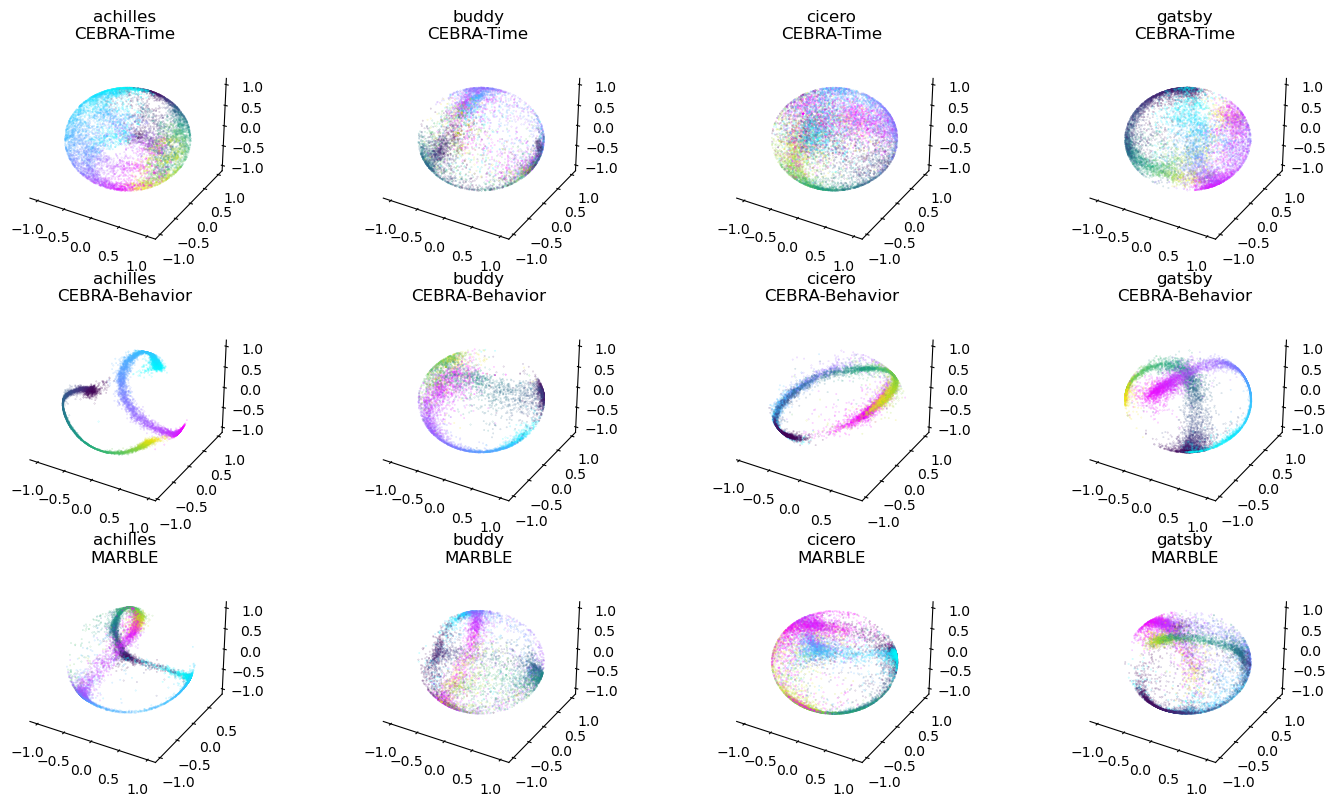

In [7]:
fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot(3,4,1, projection='3d')
ax2 = plt.subplot(3,4,2, projection='3d')
ax3 = plt.subplot(3,4,3, projection='3d')
ax4 = plt.subplot(3,4,4, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

ax1 = plt.subplot(3,4,5, projection='3d')
ax2 = plt.subplot(3,4,6, projection='3d')
ax3 = plt.subplot(3,4,7, projection='3d')
ax4 = plt.subplot(3,4,8, projection='3d')
axs_middle = [ax1, ax2, ax3, ax4]

ax1 = plt.subplot(3,4,9, projection='3d')
ax2 = plt.subplot(3,4,10, projection='3d')
ax3 = plt.subplot(3,4,11, projection='3d')
ax4 = plt.subplot(3,4,12, projection='3d')
axs_down = [ax1, ax2, ax3, ax4]

for ax, mouse in  zip(axs_up, list(time_embeddings.keys())): 
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=time_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse]['continuous_index'][dir,0], title=f"{mouse}\nCEBRA-Time", cmap=cmap)

for ax, mouse in  zip(axs_middle, list(posdir_embeddings.keys())): 
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=posdir_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse]['continuous_index'][dir,0], title=f"{mouse}\nCEBRA-Behavior", cmap=cmap)

for ax, mouse in  zip(axs_down, list(marble_embeddings.keys())): 
    for dir, cmap in zip([right_marble[mouse], left_marble[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=marble_embeddings[mouse][dir,:], embedding_labels=labels_marble[mouse][dir,0], title=f"{mouse}\nMARBLE", cmap=cmap)

plt.tight_layout()      
plt.show()

## Compute the consistency maps

Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [8]:
# labels to align the subjects is the position of the mouse in the arena
labels = [hippocampus_pos[mouse]['continuous_index'][:, 0]
          for mouse in list(hippocampus_pos.keys())]

# CEBRA-Time consistencies
time_scores, time_pairs, time_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(time_embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=list(
                                                                                 time_embeddings.keys()),
                                                                                 between="datasets")

# CEBRA-Behavior consistencies
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(posdir_embeddings.values()),
                                                                                       labels=labels,
                                                                                       dataset_ids=list(
                                                                                       posdir_embeddings.keys()),
                                                                                       between="datasets")

# MARBLE consistencies
marble_scores, marble_pairs, marble_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(marble_embeddings.values()),
                                                                                 labels=[labels_marble[rat][:,0] for rat in labels_marble.keys()],
                                                                                 dataset_ids=list(
                                                                                 marble_embeddings.keys()),
                                                                                 between="datasets")


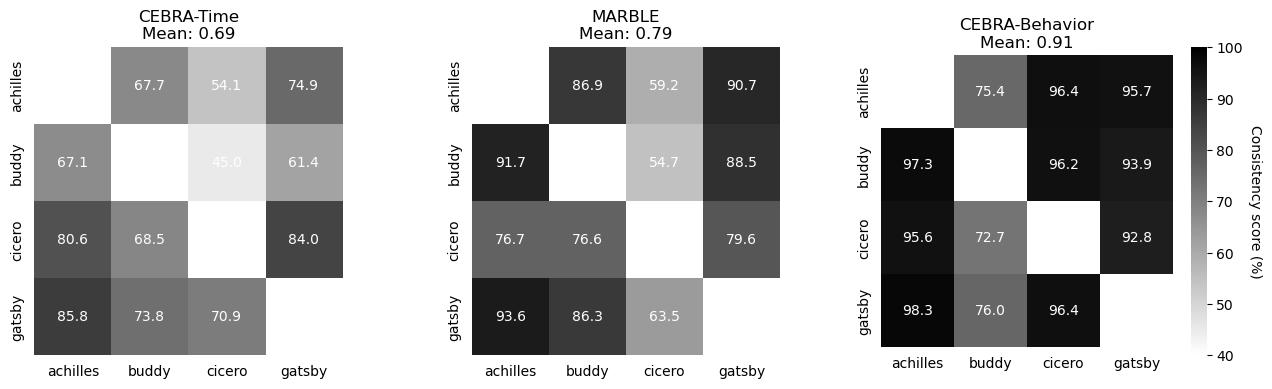

In [9]:
%matplotlib inline

# Display consistency maps
fig = plt.figure(figsize=(16, 4))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1 = cebra.plot_consistency(time_scores, pairs=time_pairs, datasets=time_subjects,
                             ax=ax1, title=f"CEBRA-Time\nMean: {np.mean(time_scores).round(2)}", 
                             colorbar_label=None, vmin=40,vmax=100)

ax2 = cebra.plot_consistency(marble_scores, pairs=marble_pairs,
                            datasets=marble_subjects, ax=ax2, title=f"MARBLE\nMean: {np.mean(marble_scores).round(2)}", 
                            colorbar_label=None, vmin=40,vmax=100)

ax3 = cebra.plot_consistency(posdir_scores, pairs=posdir_pairs, datasets=posdir_subjects, ax=ax3,
                            title=f"CEBRA-Behavior\nMean: {np.mean(posdir_scores).round(2)}", 
                             vmin=40,vmax=100)